In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import random
import warnings
warnings.filterwarnings('ignore')

# Test Notebook

Bu notebook pickle ile hazırlanmış iki modelin sonuçlarının daha hızlı bir şekilde görüntülenmesi için hazırlanmıştır. 5000 verilik test datası kullanılacaktır.

## Test Dosyasının Yüklenmesi

Test için iki farklı excel dosyası bulunmaktadır. Bu dosyalardan ***"Test_data_Actual"***, içerisinde ***"NK_FLAG(hedef değişken)"*** kolonunu barındırır. Bu kolonu ***"Test_data"*** verisindeki NK_FLAG kolonuna eşitlemeliyiz.

In [3]:
df = pd.read_excel("Test_Data.xlsx")
df1 = pd.read_excel("Test_Data_Actual.xlsx")
df.head()

,INDEX,TUKETIM_M1,TUKETIM_M2,TUKETIM_M3,TUKETIM_M4,TUKETIM_M5,TUKETIM_M6,TUKETIM_M7,TUKETIM_M8,TUKETIM_M9,...,SAYAC_BASLANGIC_TARIHI,SAYAC_BITIS_TARIHI,SAYAC_MARKA,SAYAC_MODEL,SAYAC_MALZEME_ID,SAYAC_OLCUM_TURU,SAYAC_FAZ_N,SAYAC_TAKILMA_TARIHI,SAYAC_YAPIM_YILI,NK_FLAG
0,1,120.655929,408.421620,441.702935,369.728331,324.862299,268.734368,228.187282,274.817339,315.189666,...,2016-10-06,9999-12-31 00:00:00,LUNA,LUN1,80000100.0,Aktif,Monofaze,2016-10-06,2010.0,NaN
1,2,5.130929,23.391071,56.158545,75.614418,83.396237,118.008646,160.092154,246.899889,265.490444,...,2020-03-13,9999-12-31 00:00:00,LUNA,LUN10-B,80001000.0,Aktif,Monofaze,2020-03-13,2020.0,NaN
2,3,13.447862,128.010848,117.153258,105.509955,113.085477,140.960083,142.909760,171.249824,186.267902,...,2016-09-21,9999-12-31 00:00:00,ELEKTROMED,EC058MBW,80000730.0,Aktif,Monofaze,2016-09-21,2014.0,NaN
3,4,11.027586,62.247614,122.927679,176.014306,78.527215,50.795497,190.349716,166.422780,236.395179,...,2016-09-27,9999-12-31 00:00:00,ELEKTROMED,EC15ATBW,80000730.0,Aktif,Trifaze,2016-09-27,2014.0,NaN
4,5,33.407857,92.741936,95.597571,114.905710,154.649526,195.838572,231.303161,261.736367,259.075685,...,2016-09-25,9999-12-31 00:00:00,ELEKTROMED,EC058MBW,80000730.0,Aktif,Monofaze,2016-09-25,2015.0,NaN


In [4]:
df1.head()
df1 = df1.drop("ID", axis=1)

In [5]:
df1.head()

,Actual (NK_FLAG)
0,0
1,0
2,0
3,0
4,0


In [6]:
df["NK_FLAG"] = df1["Actual (NK_FLAG)"]

In [7]:
df
df = df.drop("INDEX", axis=1)

## Test Dosyasının Tahminlemeye Hazırlanması

Bu kısımdan itibaren ana notebook'ta yapılan işlemler sırasıyla test datasına uygulanacaktır.

In [8]:
df

,TUKETIM_M1,TUKETIM_M2,TUKETIM_M3,TUKETIM_M4,TUKETIM_M5,TUKETIM_M6,TUKETIM_M7,TUKETIM_M8,TUKETIM_M9,TUKETIM_M10,...,SAYAC_BASLANGIC_TARIHI,SAYAC_BITIS_TARIHI,SAYAC_MARKA,SAYAC_MODEL,SAYAC_MALZEME_ID,SAYAC_OLCUM_TURU,SAYAC_FAZ_N,SAYAC_TAKILMA_TARIHI,SAYAC_YAPIM_YILI,NK_FLAG
0,120.655929,408.421620,441.702935,369.728331,324.862299,268.734368,228.187282,274.817339,315.189666,325.868031,...,2016-10-06,9999-12-31 00:00:00,LUNA,LUN1,80000100.0,Aktif,Monofaze,2016-10-06,2010.0,0
1,5.130929,23.391071,56.158545,75.614418,83.396237,118.008646,160.092154,246.899889,265.490444,159.416667,...,2020-03-13,9999-12-31 00:00:00,LUNA,LUN10-B,80001000.0,Aktif,Monofaze,2020-03-13,2020.0,0
2,13.447862,128.010848,117.153258,105.509955,113.085477,140.960083,142.909760,171.249824,186.267902,150.892686,...,2016-09-21,9999-12-31 00:00:00,ELEKTROMED,EC058MBW,80000730.0,Aktif,Monofaze,2016-09-21,2014.0,0
3,11.027586,62.247614,122.927679,176.014306,78.527215,50.795497,190.349716,166.422780,236.395179,252.871134,...,2016-09-27,9999-12-31 00:00:00,ELEKTROMED,EC15ATBW,80000730.0,Aktif,Trifaze,2016-09-27,2014.0,0
4,33.407857,92.741936,95.597571,114.905710,154.649526,195.838572,231.303161,261.736367,259.075685,236.816803,...,2016-09-25,9999-12-31 00:00:00,ELEKTROMED,EC058MBW,80000730.0,Aktif,Monofaze,2016-09-25,2015.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,96.545800,215.371400,232.255030,235.066393,138.072986,21.856453,51.859771,117.052383,143.554783,179.532500,...,2019-03-16,9999-12-31 00:00:00,LUNA,LSM-35,80000990.0,Aktif,Trifaze,2019-03-16,2018.0,0
4996,59.364375,73.611825,71.237250,73.611825,71.237250,73.611825,66.488100,73.611825,73.611825,71.237250,...,2015-07-29,9999-12-31 00:00:00,LUNA,LUN1,80000100.0,Aktif,Monofaze,2015-07-29,2011.0,0
4997,83.714654,233.369146,236.073354,238.351476,177.955340,193.777530,348.518155,564.013095,462.240917,216.210365,...,2016-10-14,9999-12-31 00:00:00,MAKEL,M500.2211,80000520.0,Aktif,Monofaze,2016-10-14,2011.0,0
4998,52.162200,173.363333,266.638017,220.301142,72.197051,76.503567,137.404932,208.833758,207.164414,129.785461,...,2017-10-07,9999-12-31 00:00:00,ELEKTROMED,EC058MCT,80000850.0,Aktif,Monofaze,2017-10-07,2017.0,0


In [9]:
# eksik kategorik degerler doldurulur

df["SAYAC_MODEL"].fillna("UNDEFINED", inplace=True)
df["SAYAC_MARKA"].fillna("UNDEFINED", inplace=True)
df["SAYAC_OLCUM_TURU"].fillna("UNDEFINED", inplace=True)
df["SAYAC_FAZ_N"].fillna("UNDEFINED", inplace=True)
df["SAYAC_YAPIM_YILI"].fillna(df["SAYAC_YAPIM_YILI"].mean(), inplace=True)

In [10]:
# kategorik degerler gruplanır

def sayac_marka(i):
    if i in ('UNDEFINED'):
        return 'Çok Yüksek Risk'
    elif i in ('LUNA'):
        return 'Yüksek Risk'
    else:
        return "Orta - Düşük Risk"
df['SAYAC_MARKA'] = df['SAYAC_MARKA'].apply(sayac_marka)


def sayac_yapim(i):
    if i >= 2015:
        return "2015 ve sonrası"
    else:
        return '2015 Öncesi'
df['SAYAC_YAPIM_YILI'] = df['SAYAC_YAPIM_YILI'].apply(sayac_yapim)

bins = [df["MAHALLE_RISK_SKORU"].min(), df["MAHALLE_RISK_SKORU"].median(), df["MAHALLE_RISK_SKORU"].quantile(0.75), df["MAHALLE_RISK_SKORU"].max()]
bin_labels = [ "Düşük", 'Orta', 'Yüksek']
df['MAHALLE_RISK_SKORU_group'] = pd.cut(df['MAHALLE_RISK_SKORU'], bins = bins, labels=bin_labels, include_lowest= True)

bins = [df["SOKAK_RISK_SKORU"].min(), df["SOKAK_RISK_SKORU"].quantile(0.75), df["SOKAK_RISK_SKORU"].max()]
bin_labels = ["Düşük", 'Yüksek']
df['SOKAK_RISK_SKORU_group'] = pd.cut(df['SOKAK_RISK_SKORU'], bins = bins, labels=bin_labels, include_lowest= True)

bins = [df["SOB_RISK_SKORU"].min(), df["SOB_RISK_SKORU"].quantile(0.25), df["SOB_RISK_SKORU"].median(), df["SOB_RISK_SKORU"].quantile(0.75), df["SOB_RISK_SKORU"].max()]
bin_labels = ["Çok Düşük", "Düşük", 'Orta', 'Yüksek']
df['SOB_RISK_SKORU_group'] = pd.cut(df['SOB_RISK_SKORU'], bins = bins, labels=bin_labels, include_lowest= True)

In [11]:
# tuketim verileri üzerine işlemler yapılır

tuketim = (df.iloc[:,0:24])# tuketim degerlerini incelemek istersek

tuketim["aylik_ort_tuketim"] = np.nan
tuketim["max_tuketim"] = np.nan
tuketim["min_tuketim"] = np.nan
tuketim["max_aylik_tuketim_dususu"] = np.nan
tuketim["max_yillik_tuketim_dususu"] = np.nan
tuketim["tuketim_null_sayisi"] = np.nan

tuketim.fillna(-1, inplace=True) # veri setindeki tum null degerler gecici olarak -1 ile doldurulur
 

tuketim1 = tuketim.iloc[:,:24]
tuketim1

monthly_avg = 0.0
monthly_min = 999.00
monthly_max = 0.0

for i in range(len(tuketim1)): # satirlar arasi dolasir
    for month in tuketim1: # sutunlar arasi dolasir
            
        if(tuketim[month].values[i] != -1): # nulları -1 ile doldurmustuk onlari ort hesabina katmiyoruz
            monthly_avg += tuketim[month].values[i]
            
        if(tuketim[month].values[i] > monthly_max): # kullanicinin aylık max tuketimi hesaplanir
            monthly_max = tuketim[month].values[i]
            
        if(tuketim[month].values[i] < monthly_min and tuketim[month].values[i] != -1): # kullanicinin aylık min tuketimi hesaplanir
            monthly_min = tuketim[month].values[i]
            
        
    monthly_avg = monthly_avg/len(tuketim1.columns)
    
    tuketim["aylik_ort_tuketim"].values[i] = monthly_avg
    tuketim["max_tuketim"].values[i] = monthly_max
    tuketim["min_tuketim"].values[i] = monthly_min
    
    monthly_avg = 0.0
    monthly_min = 999.00
    monthly_max = 0.0
    temp = 0
    
counter = 0

for i in range(len(tuketim1)): # satirlar arasi dolasir
    for month in tuketim1: # sutunlar arasi dolasir  
        if(tuketim[month].values[i] == -1): # nulları -1 ile doldurmustuk, deger null ise buraya girer
            tuketim[month].values[i] = tuketim["aylik_ort_tuketim"].values[i] # -1 olan deger, ort ile degistirildi
            counter += 1
    tuketim["tuketim_null_sayisi"].values[i] = counter   
            
    counter = 0
    
consumption_diff = 0 
temp = 0

for i in range(len(tuketim1)): # satirlar arasi dolasir
    for month in tuketim1: # sutunlar arasi dolasir      
        if(temp < tuketim[month].values[i]): # düsüs varsa fark hesaplanir
            if(tuketim[month].values[i] != tuketim["aylik_ort_tuketim"].values[i] and temp != tuketim["aylik_ort_tuketim"].values[i] ): # degerler null degilse fark hesaplanir
                diff = abs(tuketim[month].values[i] - temp)    
                if(diff > consumption_diff and temp != 0):
                    consumption_diff = diff
            
        temp = tuketim[month].values[i]
        
    tuketim["max_aylik_tuketim_dususu"].values[i] = consumption_diff
    consumption_diff = 0 
    temp = 0
    
#tuketim icin aynı ayi yil bazinda karsilastirdim, farkini alinip yillik tuketim dususu hesaplanir

months = []
for x in tuketim1:
    months.append(x)

len_m = int(len(months)/2)

yearly_max = 0

for i in range(len(tuketim1)): # satir bazinda dolasir
    for j in range(len_m): # sutun bazinda dolasir
        month = months[j] # yakin tarih
        nmonth = months[j+12]
        if(tuketim[month].values[i] < tuketim[nmonth].values[i] ): # düsüs varsa fark hesapla
            if(tuketim[month].values[i] != tuketim["aylik_ort_tuketim"].values[i] and tuketim[nmonth].values[i] != tuketim["aylik_ort_tuketim"].values[i] ): # aylardan biri null degilse degisim hesapla
                diff = abs(tuketim[month].values[i] - tuketim[nmonth].values[i])
                if(diff > yearly_max):
                    yearly_max = diff
    tuketim["max_yillik_tuketim_dususu"].values[i] = yearly_max
    yearly_max = 0
    


In [12]:
# demand verileri üzerine işlemler yapılır

demand = df.iloc[:,24:36].copy() # demand degerlerini incelemek istersek

# demande 5 yeni kolon ekle

demand["aylik_ort_demand"] = np.nan
demand["max_demand"] = np.nan
demand["min_demand"] = np.nan
demand["max_aylik_demand_degisimi"] = np.nan
demand["demand_null_sayisi"] = np.nan

demand.fillna(-1, inplace=True)

demand1 = demand.iloc[:,:12]

monthly_avg = 0.0
monthly_min = 999.00
monthly_max = 0.0
demand_diff = 0 
temp = 0


for i in range(len(demand1)): # satirlar arasi dolasir
    for month in demand1: # sutunlar arasi dolasir
        
        if(demand[month].values[i] != -1 and temp != -1): # degerler null degilse fark hesaplanir
            diff = abs(demand[month].values[i] - temp)
            if(diff > demand_diff and temp != 0):
                demand_diff = diff
            temp = demand[month].values[i]
            
        if(demand[month].values[i] != -1): # nulları -1 ile doldurmustuk onlari ort hesabina katmiyoruz
            monthly_avg += demand[month].values[i]
            
        if(demand[month].values[i] > monthly_max): # kullanicinin aylık max tuketimi hesaplanir
            monthly_max = demand[month].values[i]
            
        if(demand[month].values[i] < monthly_min and demand[month].values[i] != -1): # kullanicinin aylık min tuketimi hesaplanir
            monthly_min = demand[month].values[i]
            
        
    monthly_avg = monthly_avg/len(demand1.columns)
    
    demand["aylik_ort_demand"].values[i] = monthly_avg
    demand["max_demand"].values[i] = monthly_max
    demand["min_demand"].values[i] = monthly_min
    demand["max_aylik_demand_degisimi"].values[i] = demand_diff
    
    monthly_avg = 0.0
    monthly_min = 999.00
    monthly_max = 0.0
    demand_diff = 0 
    temp = 0.0
    

# null (-1) demand degerleri kullanicinin aylik ort demandi ile doldurulur, null sayisi hesaplanir

for i in range(len(demand1)): # satirlar arasi dolasir
    for month in demand1: # sutunlar arasi dolasir  
        if(demand[month].values[i] == -1): # nulları 0 ile doldurmustuk
            demand[month].values[i] = demand["aylik_ort_demand"].values[i] # -1 olan deger, ort ile degistirildi
            counter += 1
    demand["demand_null_sayisi"].values[i] = counter
    counter = 0
    

# demand / tuketim orani -> max orani tut
# tuketimleri 12 aya düsür -> demand / tuketimlerin yillik farki -> 0-1 arası deger alabilir

demand["max_demand/tuketim_orani"] = np.nan

months = []
for x in tuketim1:
    months.append(x)

dmonths = []
for x in demand1:
    dmonths.append(x)
    
len_m = 12 # 12 ay verir
max_percent = 0


for i in range(len(tuketim)): # satir bazinda dolasir
    for j in range(len_m):
        month = months[j]
        nmonth = months[j+12]
        dmonth = dmonths[j]
        
        diff = abs(tuketim[month].values[i] - tuketim[nmonth].values[i])
 
        if(diff >= demand[dmonth].values[i]):
            percent = demand[dmonth].values[i] / diff 
            if(percent > max_percent):
                max_percent = percent
    demand["max_demand/tuketim_orani"].values[i] = max_percent      
    max_percent = 0
    

# kullanıcıların davranışına göre olağandışı (outlier) tüketim yaptıkları ay sayısı hesaplanır

transpozed_df = df.iloc[:, 0:24].T
Q1 = transpozed_df.quantile(0.25)
Q3 = transpozed_df.quantile(0.75)
IQR = Q3 - Q1
demand["OUTLIER_SAYISI"] = ((transpozed_df < (Q1 - 1.5 * IQR)) | (transpozed_df > (Q3 + 1.5 * IQR))).sum()

In [13]:
# ordinal encoding

df["MAHALLE_RISK_SKORU_group_encoded"] = df["MAHALLE_RISK_SKORU_group"].map(
    {'Düşük':1, 'Orta':2, 'Yüksek':3})

df["SOKAK_RISK_SKORU_group_encoded"] = df["SOKAK_RISK_SKORU_group"].map(
    {'Düşük':1,'Yüksek':2})

df["SOB_RISK_SKORU_group_encoded"] = df["SOB_RISK_SKORU_group"].map(
    {'Çok Düşük':1, 'Düşük':2,'Orta':3, 'Yüksek':4})

df["SAYAC_MARKA_encoded"] = df["SAYAC_MARKA"].map(
    {'Orta - Düşük Risk':1, 'Yüksek Risk':2,'Çok Yüksek Risk':3})

ordinal_columns = ["MAHALLE_RISK_SKORU_group", "SOKAK_RISK_SKORU_group", "SOB_RISK_SKORU_group", "SAYAC_MARKA"]
df = df.drop(ordinal_columns, axis=1)

others = df.iloc[:,36:54].copy() # kalan feature'lari incelemek icin

df = pd.concat([tuketim,demand,others], axis=1)

In [14]:
# kullanılmayan kolonların drop edilmesi

drops = ["SAYAC_MODEL", "SAYAC_MALZEME_ID",
         "SAYAC_BASLANGIC_TARIHI", "SAYAC_BITIS_TARIHI", 
         "SAYAC_TAKILMA_TARIHI", "SOB_RISK_SKORU", "SOKAK_RISK_SKORU", "MAHALLE_RISK_SKORU"]
df.drop(drops,axis=1,inplace=True)

In [15]:
# dağılımdaki çarpıklığı azaltma

for i in df.iloc[:, 0:49]:
    df[i] = df[i]**(.5)
    
#çarpıklığı düzeltme işleminden sonra ortaya çıkan 2 null verinin doldurulması
df["TUKETIM_M24"].fillna(18,inplace=True)
df["min_tuketim"].fillna(18,inplace=True)

## One Hot Encoder

In [16]:
cat_cols = ["TESISAT_TIPI","SAYAC_OLCUM_TURU", "SAYAC_FAZ_N", "SAYAC_YAPIM_YILI"]
for col in cat_cols:
    df[col] = df[col].astype('object')

columns_to_encode = []
for col in df.columns:
    if df[col].dtype == 'object':
        columns_to_encode.append(col)
columns_to_encode

['TESISAT_TIPI', 'SAYAC_OLCUM_TURU', 'SAYAC_FAZ_N', 'SAYAC_YAPIM_YILI']

In [17]:
# Kolon isimlerinin sırasını almak için get_dummies yapıyorum.
# OneHotEncoding yapınca kolon isimleri kayboluyor.
df_temp = pd.get_dummies(df, columns = columns_to_encode)
cl=[]
for _ in df_temp.columns:
    cl.append(_)
cl # OHE yapılmış datamızın tüm kolon isimleri.

['TUKETIM_M1',
 'TUKETIM_M2',
 'TUKETIM_M3',
 'TUKETIM_M4',
 'TUKETIM_M5',
 'TUKETIM_M6',
 'TUKETIM_M7',
 'TUKETIM_M8',
 'TUKETIM_M9',
 'TUKETIM_M10',
 'TUKETIM_M11',
 'TUKETIM_M12',
 'TUKETIM_M13',
 'TUKETIM_M14',
 'TUKETIM_M15',
 'TUKETIM_M16',
 'TUKETIM_M17',
 'TUKETIM_M18',
 'TUKETIM_M19',
 'TUKETIM_M20',
 'TUKETIM_M21',
 'TUKETIM_M22',
 'TUKETIM_M23',
 'TUKETIM_M24',
 'aylik_ort_tuketim',
 'max_tuketim',
 'min_tuketim',
 'max_aylik_tuketim_dususu',
 'max_yillik_tuketim_dususu',
 'tuketim_null_sayisi',
 'DEMAND_M1',
 'DEMAND_M2',
 'DEMAND_M3',
 'DEMAND_M4',
 'DEMAND_M5',
 'DEMAND_M6',
 'DEMAND_M7',
 'DEMAND_M8',
 'DEMAND_M9',
 'DEMAND_M10',
 'DEMAND_M11',
 'DEMAND_M12',
 'aylik_ort_demand',
 'max_demand',
 'min_demand',
 'max_aylik_demand_degisimi',
 'demand_null_sayisi',
 'max_demand/tuketim_orani',
 'OUTLIER_SAYISI',
 'NK_FLAG',
 'MAHALLE_RISK_SKORU_group_encoded',
 'SOKAK_RISK_SKORU_group_encoded',
 'SOB_RISK_SKORU_group_encoded',
 'SAYAC_MARKA_encoded',
 'TESISAT_TIPI_Mesken',


In [18]:
num_val = df_temp.iloc[:,:54] # Nümerik verilerimiz tamamı
cat_val = cl[54:] # OHE yapılmış kolonlarımızın isimleri

from sklearn.preprocessing import OneHotEncoder
# Validation kısmında hata almamak için "handle_unknown=ignore" olarak ayarladım.
ohe = OneHotEncoder(handle_unknown='ignore') 
dfohe=ohe.fit_transform(df[columns_to_encode]).toarray() # Object verilerimize OHE uyguladık.
dfohe

array([[1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       ...,
       [1., 0., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 1.]])

In [19]:
num_val.reset_index(drop=True, inplace=True)
df4=pd.DataFrame(dfohe, columns=cat_val) # OHE yapılmış verilerimizin DF'i
df_test = pd.concat([num_val,df4], axis=1) # Önceden ayırdığımız nümeric veriler ile OHE verimizi birleştirdik.
df_test.head(10) # TRAIN datamızın tüm işlemlerden geçmiş hali bu.

,TUKETIM_M1,TUKETIM_M2,TUKETIM_M3,TUKETIM_M4,TUKETIM_M5,TUKETIM_M6,TUKETIM_M7,TUKETIM_M8,TUKETIM_M9,TUKETIM_M10,...,TESISAT_TIPI_Mesken,TESISAT_TIPI_Ticarethane-Sanayi,SAYAC_OLCUM_TURU_Aktif,SAYAC_OLCUM_TURU_Kombi,SAYAC_OLCUM_TURU_UNDEFINED,SAYAC_FAZ_N_Monofaze,SAYAC_FAZ_N_Trifaze,SAYAC_FAZ_N_UNDEFINED,SAYAC_YAPIM_YILI_2015 ve sonrası,SAYAC_YAPIM_YILI_2015 Öncesi
0,10.984349,20.209444,21.016730,19.228321,18.023937,16.393120,15.105869,16.577616,17.753582,18.051815,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2.265155,4.836432,7.493901,8.695655,9.132154,10.863178,12.652753,15.713048,16.293878,12.626031,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,3.667133,11.314188,10.823736,10.271804,10.634166,11.872661,11.954487,13.086246,13.648000,12.283838,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,3.320781,7.889716,11.087276,13.267038,8.861558,7.127096,13.796728,12.900495,15.375148,15.901922,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,5.779953,9.630261,9.777401,10.719408,12.435816,13.994234,15.208654,16.178268,16.095828,15.388853,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,5.887818,22.167035,13.513943,10.420718,7.101889,6.014920,5.924194,7.447502,7.714867,7.961699,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,0.031623,0.043549,0.046238,0.046688,0.049135,5.431874,19.308722,16.480849,0.000000,0.046098,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,0.531594,0.977347,1.126033,1.460223,1.707630,1.858581,2.809953,3.463667,4.490283,7.775078,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,38.290250,50.249622,50.360112,49.619547,44.723646,41.863827,47.883607,50.222382,44.102687,43.057314,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9,0.000000,1.905413,1.556013,2.670932,0.534178,0.231595,9.450555,26.545298,6.938337,0.000000,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## Veri Setinin Predictor (X) - Target (y) Olarak Ayrılması

In [20]:
# Train datamızın bölünmesi
features = []
for col in df_test.columns:
    if col != 'NK_FLAG':
        features.append(col)

target = 'NK_FLAG'

X = df_test[features]
y = df_test[target]

## Verilerin Scale Edilmesi

In [21]:
# X verimizi scale ediyoruz.
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

## Tahminleme İşlemi ve Değerlendirme

Elimizdeki en iyi sonuçları veren iki model incelenecektir.

In [43]:
# trainde kaydedilen model dosyası yüklenir
import pickle
model_svc = pickle.load(open("svc_model.pkl","rb"))
model_logreg = pickle.load(open("logreg_model.pkl","rb"))

### SVC

89.62

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      4687
           1       0.37      0.90      0.52       313

    accuracy                           0.90      5000
   macro avg       0.68      0.90      0.73      5000
weighted avg       0.95      0.90      0.92      5000



<AxesSubplot:>

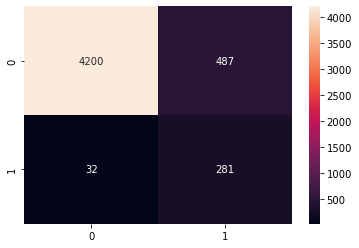

In [44]:
preds_svc = model_svc.predict(X)
score_svc = model_svc.score(X, y)
print(score_svc*100)
print()
print(classification_report(y, preds_svc))

cm = confusion_matrix(y, preds_svc)
sns
sns.heatmap(cm, annot=True, fmt='g')

#### SVC(Threshold Yapılmış Hali) 

Valuation for test data only:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      4687
           1       0.37      0.90      0.52       313

    accuracy                           0.90      5000
   macro avg       0.68      0.90      0.73      5000
weighted avg       0.95      0.90      0.92      5000

----------------------------------------------------------------------
Valuation for test data only  (new_threshold):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4687
           1       0.70      0.70      0.70       313

    accuracy                           0.96      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.96      0.96      0.96      5000



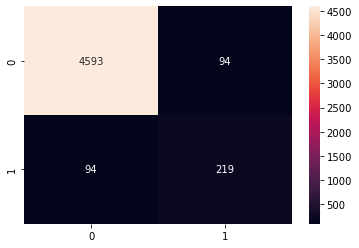

In [62]:
threshold = 0.9
predictions_svc = (model_svc.predict_proba(X)[:, 1] >= threshold).astype(int)

cm = confusion_matrix(y, predictions_svc)
sns
sns.heatmap(cm, annot=True, fmt='g')

print('Valuation for test data only:')
print(classification_report(y, preds_svc))
print("----------------------------------------------------------------------")
print('Valuation for test data only  (new_threshold):')
print(classification_report(y, predictions_svc))

### Logistic Regression

90.2

              precision    recall  f1-score   support

           0       0.99      0.90      0.95      4687
           1       0.38      0.89      0.53       313

    accuracy                           0.90      5000
   macro avg       0.69      0.90      0.74      5000
weighted avg       0.95      0.90      0.92      5000



<AxesSubplot:>

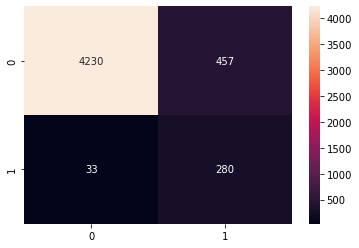

In [28]:
preds_logreg = model_logreg.predict(X)
score_logreg = model_logreg.score(X, y)
print(score_logreg*100)
print()
print(classification_report(y, preds_logreg))

cm = confusion_matrix(y, preds_logreg)
sns
sns.heatmap(cm, annot=True, fmt='g')

#### Logistic Regression(Threshold Yapılmış Hali) 

Valuation for test data only:
              precision    recall  f1-score   support

           0       0.99      0.90      0.95      4687
           1       0.38      0.89      0.53       313

    accuracy                           0.90      5000
   macro avg       0.69      0.90      0.74      5000
weighted avg       0.95      0.90      0.92      5000

----------------------------------------------------------------------
Valuation for test data only  (new_threshold):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4687
           1       0.69      0.71      0.70       313

    accuracy                           0.96      5000
   macro avg       0.83      0.84      0.84      5000
weighted avg       0.96      0.96      0.96      5000



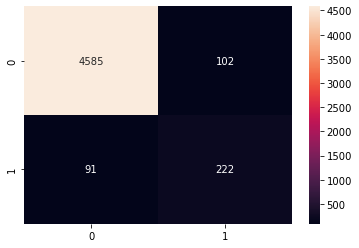

In [63]:
threshold = 0.89
predictions_lr = (model_logreg.predict_proba(X)[:, 1] >= threshold).astype(int)

cm = confusion_matrix(y, predictions_lr)
sns
sns.heatmap(cm, annot=True, fmt='g')

print('Valuation for test data only:')
print(classification_report(y, preds_logreg))
print("----------------------------------------------------------------------")
print('Valuation for test data only  (new_threshold):')
print(classification_report(y, predictions_lr))

## SONUÇ

- SVC için(Threshold sonrası):
    * F1 Skoru: 0.70
    * Recall: 0.70
    * Precision: 0.70
- Logistic Regression için(Threshold sonrası):
    * F1 Skoru: 0.70
    * Recall: 0.71
    * Precision: 0.69